# PhenoGrpah Pipeline 
# 1/4 Preprocessing and Phenotype Profiling
This notebook follows the pipeline proposed by Levine et al, focusing on analysing cluster-based phenotype profiling of single cell mass cytometry data to reveal AML subpopulations with prognostic value. Assuming you have downloaded all the data you need from CytoBank with the total amount of 18 x 21 files, and all the data has already been clustered according to the Supplementary(**sample_wise, k = 50**).


In [1]:
#!/usr/bin/env python3
from __future__ import division
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from scipy import stats
import re
import phenograph as pg
import os
from IPython.display import clear_output


## Applying PhenoGraph to Pediatric Cohort and Healthy Donors
We ran PhenoGraph on each sample (AML patient or healthy donor) individually, defining subpopulations based on expression of the 16 measured surface markers. While pooling multiple samples may facilitate immediate comparison across samples by placing cells from different samples into the same cluster, this approach is vulnerable to bias caused by **sample size** and may produce clusters that are difficult to interpret. 

We wanted to create a profile of each sample and ensure that **each reported subpopulation was indeed present, rather than an outlier spuriously associated with a subpopulation present in a different sample**. The **1.3–16 x 105 cells collected per sample** were **sufficient to detect rare subpopulations** (as low as **0.06%** of the sample). Additionally, since there is tube-to-tube variation in antibody staining, **PhenoGraph was run on directly comparable cells stained within the same barcoded tube**.

For each healthy volunteer or patient sample, single-cell measurements from all **16 ex vivo conditions** (**including the two basal control conditions**), which were all measured together in a single barcoded tube, were pooled and compiled into a single data matrix. This pooling both increased the total number of cells, **facilitating the identification of rare populations and later enabled characterization of subpopulation-specific signaling dynamics**. **PhenoGraph was run using only the 16 surface markers to define phenotypic similarity**. **We assumed that the surface markers do not change within 15 minutes following stimulation** (as previously demonstrated in (Bendall et al., 2011)), thus making these directly comparable across conditions. PhenoGraph was run on the **normalized surface marker matrices for each sample**, with the parameter **k=50**. We reasoned that 50 neighbors was a sufficiently large number to estimate the geometry of the local neighborhood while being small enough to avoid inappropriately large neighborhoods. 

This yielded **an average of 28 subpopulations per sample (ranging between 17 and 48), totaling 641 subpopulations **across the entire cohort of healthy and leukemic samples. Subpopulation size varied by orders of magnitude, from 7x10e2 to 2x10e5 cells (or .06% to 20% of a sample).

### WATCH OUT: Inconsistent results from CytoBank Dataset
The total number of subpopulations across healthy and leukemic samples are **706**, in which **490** are leukemic. And for SJ05 and SJ09, there exist **2** subsets missing in basal conditions but existing in stimulated conditions. To retain the consistency from supplementary and dataset, the 706 subsets were kept. 

## Cell abundance in each sample
We found the SJ05 and SJ12 were two measures of most abundance. And most health sample sizes were smaller than AML ones.
And the clustering consequences(a few tries) were different from what is claimed in Supplementary.
Cell frequencies of each sample (each has 18 conditions: 2 basal conditions and 16 stimulated ones) are listed and these are consistent with what is claim in the Supplementary.

In [91]:
import numpy as np
import pandas as pd
import fcs_reader as fcsrd
import glob
import os
# set global variables
n_patients = 5 + 16;
n_conditions = 18;
import phenograph as pg

fnames = glob.glob('../experiment_44185_files/*.fcs')
# under linux the list of file names are not automatically sorted alphabeticallly
fnames = np.sort(fnames)

sample_names = []
cell_frequencies = []
n_clusters = []
for i in range(n_patients):
#     slice 18 files from current sample
    fname = fnames[n_conditions*i:n_conditions*(i+1)]
#     print(fname)
#    create folder 
    sample_name = fname[0].split('/')
    sample_name = sample_name[-1]
    sample_name = sample_name.split('_')
    sample_name = sample_name[0]
    
    
    if os.path.exists(sample_name) == False:
        os.mkdir(sample_name)
#     save sample name    
    sample_names.append(sample_name)   
    
#     count number of cells
    for ii in (fname):
        if ii == fname[0]:           
            meta, data_numpy = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='ndarray', reformat_meta=True)
#            surface_marker_data = data_numpy[:,surface_marker.index - 1]
            surface_marker_data = data_numpy           
        else:
            meta, data_numpy = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='ndarray', reformat_meta=True)      
            surface_marker_data = np.vstack((surface_marker_data,data_numpy))
            
    cell_frequencies.append(surface_marker_data.shape[0])
    n_clusters.append(sum(np.unique(surface_marker_data[:,-1])>=0))


      cell_frequencies  cluster_number
H1              235033              34
H2              630554              45
H3              514754              40
H4              718642              46
H5              927149              51
SJ01            936673              28
SJ02            645517              30
SJ03            442099              29
SJ04            463903              26
SJ05           1306251              38
SJ06            516538              29
SJ07            190992              28
SJ08            137617              33
SJ09            489189              35
SJ10            860106              32
SJ11            537553              32
SJ12           1601151              32
SJ13            726117              29
SJ14           1355947              35
SJ15           1054435              29
SJ16           1057909              29
The average number of cells in each sample is 730863
The total number of cells in all the samples is 15348129
The average number of clusters i

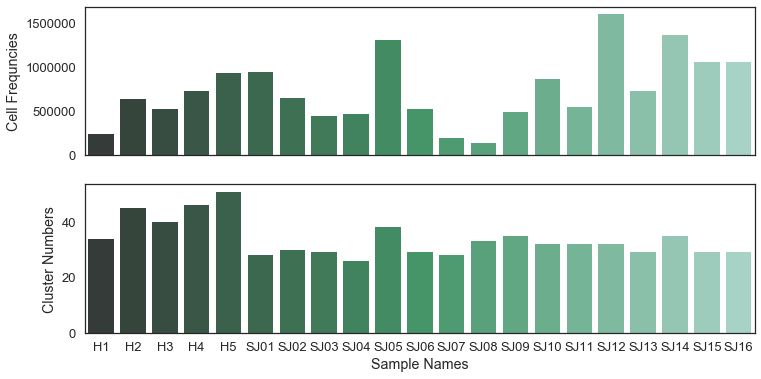

In [92]:
# plot histogram of cell frequencies in each 
sample_df = pd.DataFrame(cell_frequencies,columns=["cell_frequencies"],index=sample_names)
sample_df["cluster_number"]  = n_clusters
print(sample_df)

print("The average number of cells in each sample is {}".format(int(sample_df["cell_frequencies"].mean())))
print("The total number of cells in all the samples is {}".format(int(sample_df["cell_frequencies"].sum())))
print("The average number of clusters in each sample is {}".format(int(sample_df["cluster_number"].mean())))
print("The total number of clusters in all the samples is {}".format(int(sample_df["cluster_number"].sum())))

import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

sns.barplot(sample_names, cell_frequencies, palette="BuGn_d", ax=ax1)
sns.barplot(sample_names, n_clusters, palette="BuGn_d", ax=ax2)
ax1.set_ylabel("Cell Frequncies")
# ax1.set_xlabel("Sample Names")
ax2.set_ylabel("Cluster Numbers")
ax2.set_xlabel("Sample Names")



We could find that the total number of clusters is larger than 641, which is claimed in the research. And after filtering with threshold of 20 it remains 637 clusters.

For each surface marker, the maximum intensity observed in healthy samples
was determined as the **99.5th percentile of the ~3 x 106 healthy bone marrow cells from the 5 donors**. The top half percentile was excluded from this determination because mass cytometry data can have high-intensity outliers. Data from all samples (healthy and AML) **were divided by these maximum values**, yielding expression values that can be interpreted as x-fold of the maximum expression observed in healthy. 

In [93]:
# calculate normalizer
#     slice 18 files from current sample
# sample_names = []
fname = fnames[n_conditions*0:n_conditions*(5)]
#     print(fname)
#    create folder 
# sample_name = fname[0].split('/')
# sample_name = sample_name[-1]
# sample_name = sample_name.split('_')
# sample_name = sample_name[0]


# if os.path.exists(sample_name) == False:
#     os.mkdir(sample_name)

#     save sample name    
# sample_names.append(sample_name)   

#     count number of cells
for ii in (fname):
    if ii == fname[0]:           
#         meta,  = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='ndarray', reformat_meta=True)
        meta, data_pandas = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='DataFrame')
#         cluster_channel = np.load(sample_name + "/final_communities.npy")
#         surface_marker_data = data_numpy
        session_data = data_pandas
    else:
#         meta, data_numpy = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='ndarray', reformat_meta=True)
        _, data_pandas = fcsrd.parse_fcs(ii, meta_data_only=False, output_format='DataFrame')
#         surface_marker_data = np.vstack((surface_marker_data,data_numpy))
#         cluster_channel = np.hstack((cluster_channel,np.load(sample_name + "/final_communities.npy")))
        session_data = pd.concat([session_data,data_pandas],axis=0)

# cell_frequencies.append(surface_marker_data.shape[0])
# n_clusters.append(sum(np.unique(surface_marker_data[:,-1])>=0))    

surface_markers = ['CD19', 'CD11b', 'CD34', 'CD45','CD123', 'CD33', 'CD47', 'CD7',
       'CD15', 'CD44', 'CD38', 'CD3', 'CD117', 'HLA-DR', 'CD64', 'CD41']

phospho_markers = ['pPLCg2','p4EBP1','pAMPK','pSTAT3', 'pSTAT5', 'pS6', 'pCREB', 'pc-Cbl', 'pSTAT1',
        'pZap70-Syk', 'pAKT', 'pRb','pErk1-2', 'pP38']

surface_H = session_data[surface_markers].values
surface_H = np.arcsinh(surface_H/5)
normalizer = np.percentile(surface_H,99.5,axis=0)

np.save("normalizer.npy",normalizer)
print(normalizer)

[ 3.01536345  4.29220604  3.78928197  7.05611007  4.79238182  3.60744673
  5.36173272  5.5717638   3.88908316  5.82454915  5.83305253  6.20264425
  1.64814562  6.19086675  3.68862985  5.96350821]


We split the data set into individual samples. [H1,H2,..,H5,SJ01,SJ02,..SJ16]. And calculated cohort phenotypes for each sample separatedly because of memory limits. 

In [94]:
# cluster each sample

# run clustering.py

# don't run this part in ipython notebook because it takes too long a time


for i in range(n_patients):
#for i in :
#     i = i + 5
    fname = fnames[n_conditions*i:n_conditions*(i+1)]
#    create folder 
    sample_name = fname[0].split('/')
    sample_name = sample_name[-1]
    sample_name = sample_name.split('_')
    sample_name = sample_name[0]
    
    if os.path.exists(sample_name) == False:
        os.mkdir(sample_name)
    
    print("###################################")
    print("reading sample {}".format(sample_name))
    
    for ii,f in enumerate(fname):
        if f == fname[0]:           
            meta, data_pandas = fcsrd.parse_fcs(f, meta_data_only=False, output_format='DataFrame', reformat_meta=True)
#            surface_marker_data = data_numpy[:,surface_marker.index - 1]
            session_data =  data_pandas 
            condition_number =  np.ones(data_pandas.shape[0])*ii
        else:
            meta, data_pandas = fcsrd.parse_fcs(f, meta_data_only=False, output_format='DataFrame', reformat_meta=True)      
            session_data = pd.concat([session_data,data_pandas],axis=0)
            condition_number = np.hstack((condition_number,np.ones(data_pandas.shape[0])*ii))
            
    print("finished reading sample {}".format(sample_name))       
    print("sample {} contains {} cells with {} dimensions".format(sample_name,session_data.shape[0],session_data.shape[1]))       
#       choose channel    
    selected_channels = surface_markers
    surface_marker_data_selected = session_data[selected_channels]
        
#       transform and normalize
    surface_marker_data_selected = np.arcsinh(surface_marker_data_selected/5)
    surface_marker_data_selected = np.divide(surface_marker_data_selected,
                                             np.tile(np.transpose(normalizer),
                                                     (np.shape(surface_marker_data_selected)[0],1)))
#     run phenograph on sample

#     directly load clustering labels already restored otherwise it will take a quite long time 
    print("PhenoGraph clustering sample {}".format(sample_name))
#     cluster_channel, graph, q = pg.cluster(surface_marker_data_selected, k=50, directed=False, prune=True, min_cluster_size=20, jaccard=True, 
#                                primary_metric='euclidean', n_jobs=4, q_tol=1e-4)
#     np.save(sample_name+"/cluster_channel.npy",cluster_channel)

#     cluster_channel = np.load(sample_name + "/final_communities.npy")
    cluster_channel = session_data["PhenoGraph"].astype('int')
    surface_marker_data_selected["PhenoGraph"] = cluster_channel
    #       choose phospho markers and transform 
    selected_channels = phospho_markers
    surface_marker_data_selected[selected_channels] = np.arcsinh(session_data[selected_channels]/5)
#     give condition number
    surface_marker_data_selected["#condition"] = np.tile(condition_number.T,(1,))
    surface_marker_data_selected["#condition"] = surface_marker_data_selected["#condition"].astype('int')
    
#     count cell numbers under every condition and every cluster
    index = []
    condition_names = ['BEZ-235','AICAR','Basal1','Basal2','Flt3L','G-CSF',
                     'GM-CSF','IFNa','IFNg','IL-3','IL-6','IL-10','IL-27','PMAiono','PVO4','SCF','TNFa','TPO']
    abundance = []
    for i in np.sort(np.unique(surface_marker_data_selected["PhenoGraph"] )): #for this cluster
        index.append(sample_name+'/'+str(i))
        for j in range(ii+1):
            abundance.append(np.sum((surface_marker_data_selected["PhenoGraph"].values == i) 
                                    & (surface_marker_data_selected["#condition"].values ==j) ))
    abundance = pd.DataFrame(np.reshape(abundance,(len(index),len(condition_names))),index=index,columns=condition_names)

    print(abundance)
    abundance.to_csv(sample_name +  "/abundance_data.csv")
    surface_marker_data_selected.to_csv(sample_name +  "/session_data.csv")
    
    print("Saving transformed and normalized data session {}".format(sample_name))
    clear_output()

print("Already transformed and normalized surface markers and tranformed phospho markers. Saving them to respective data sessions")


Already transformed and normalized surface markers and tranformed phospho markers. Saving them to respective data sessions


## Defining Subpopulation Phenotypes
Subpopulation **surface and signaling phenotypes** were computed for each cluster returned by PhenoGraph. Subpopulation surface phenotypes were defined simply as the **median value** of each surface marker among all cells in that cluster. Subpopulation signaling phenotypes were computed by **SARA**, followed by **z-score standardization**. SARA was computed for each **phospho-marker X stimulation pair** by comparing cells collected in the basal and post-stimulation condition, as described above. A vast majority of subpopulations contained sufficient cells from all conditions to compute signaling phenotypes. Subpopulations that contained **less than 20 cells from all conditions were excluded** from further analysis (**25/641** original clusters), resulting in **616 (191 healthy + 425 AML)** cohort subpopulations.

To facilitate comparability across samples and signaling phenotypes, SARA scores were converted into z-scores. The **dynamic range of SARA scores varied substantially between conditions**. For example, the chemical perturbation pervanadate produced much more dramatic responses than biological stimulations such as IL-3. Additionally, we noted **subtle sample- specific biases** in these dynamic ranges, likely due to inevitable differences in handling of primary human samples from day to day. Therefore, within each condition and sample, we pooled SARA values from all subpopulations and all phospho-markers and standardized the SARA scores by re-expressing them as z-scores. Thus each value in the signaling phenotype represents the relative magnitude of the response, within the contexts of condition and sample. Moreover, we expect that most conditions do not affect every phospho-marker in every subpopulation; and indeed, SARA scores induced by each condition had a single peak near zero. Thus, the use of z-scores also enhance interpretability by bringing insignificant fluctuations down to zero, highlighting the most significant responses .

In [95]:
# calculate surface phenotypical centroids

# run meta_cluster.py

selected_channels = surface_markers
for s in sample_names:   
#     selected_channels = surface_markers
    session_data = pd.read_csv(s + "/session_data.csv",index_col=0)
    session_data = session_data[session_data["PhenoGraph"] >=0]
    
    labels = np.sort(np.unique(session_data["PhenoGraph"].values))
    index_name = []
    abundance = []
    for l in labels:
        index_name.append(s + '/' + str(int(l)))
        this_cluster = session_data[session_data["PhenoGraph"] == l][selected_channels]
        abundance.append(this_cluster.shape[0])
        if l == labels[0]:
            centroids = this_cluster.median()
#             print(centroids)
        else:
            centroids = pd.concat([centroids, this_cluster.median()],axis = 1)   
    centroids = centroids.T
    centroids["abundance"] = abundance
    
    centroids.index = index_name
    
    abundance_data = pd.read_csv(s + "/abundance_data.csv",index_col=0)
    centroids = centroids.join(abundance_data)
    
    centroids.to_csv(s + "/session_centroids.csv")
    
    print("Finished calculating sample centroids {}".format(s))
clear_output()        
print("Finished calculating all sample centroids")

Finished calculating all sample centroids


In [96]:
# calculate signaling phenotypical centroids and combine to a csv

# run SARA.py and combine.py
from scipy import stats
def sara(basal,sti,niter=100):
    if len(basal) == 0 or len(sti) == 0:
        return 0
    D, p_val = stats.ks_2samp(basal,sti)

    pool = np.concatenate((basal,sti))
    xedges = np.linspace(min(pool),max(pool),100)
    
    hist_b, _ = np.histogram(basal,xedges)
    hist_s, _ = np.histogram(sti,xedges)
    
    hist_b = np.cumsum(hist_b/(hist_b.sum()))
    hist_s = np.cumsum(hist_s/(hist_s.sum()))
    
    emd = np.sum(np.abs(hist_s - hist_b))
    
    return np.sign(np.median(sti) - np.median(basal)) * emd * (1 - p_val)

SARA is defined in Python according to MATLAB code, the test method was substituded by scipy.stats.ks_2samp.

$EMD = \sum_\phi  F(\phi_s) - F(\phi_b) $

$SARA = EMD \times sign(E(\phi_s) - E(\phi_b)) \times p$

In [97]:
selected_channels = phospho_markers
stimulation_names = ['BEZ-235','AICAR','Flt3L','G-CSF',
                     'GM-CSF','IFNa','IFNg','IL-3','IL-6','IL-10','IL-27','PMAiono','PVO4','SCF','TNFa','TPO']

basals_ix = [2,3]
stimulates_ix = [0,1,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
SARA_names = [(x + "→" + y) for x in stimulation_names for y in phospho_markers]


In [99]:

for s in sample_names[:]:
    
    
    session_data = pd.read_csv(s + "/session_data.csv")
#     print(session_data.columns)
    session_data = session_data[session_data["PhenoGraph"] >=0]
    
    labels = np.sort(np.unique(session_data["PhenoGraph"].values))
    
    SARAs = []
    index_name = []
#     abundance = []
    for l in labels:
        index_name.append(s + '/' + str(int(l)))
        this_cluster = session_data[session_data["PhenoGraph"] == l]
        basals = this_cluster[this_cluster["#condition"].astype("int").isin(basals_ix)][selected_channels]
        for iii,sti in enumerate(stimulates_ix):
            stimulates = this_cluster[this_cluster["#condition"].astype("int") == sti][selected_channels]

            
            for sc in selected_channels:
                SARAs.append(sara(basals[sc].values,stimulates[sc].values))
                    
    SARAs = np.array(SARAs)
    SARAs = np.reshape(SARAs,(len(labels),len(selected_channels)*len(stimulates_ix)))
    
    SARAs = pd.DataFrame(SARAs,index=index_name,columns = SARA_names )
    SARAs.to_csv(s+"/session_sara.csv")
    
    print("Finished calculating sample SARAs {}".format(s))

clear_output()
print("Finished all the sample SARAs")

Finished all the sample SARAs


Combine surface medians and z-scored SARAs. Exclude cluster with less than 20 cell under **any**/more than 2 conditions. After this part, an csv file named **session_nodes.csv** will be saved to the same file and can be loaded by furthur part of analysis. It contains rows of cluster and sample number, and cols of surface markers, saras, cell frequencies under each condition and total cell frequencies.

In [100]:
for i,s in enumerate(sample_names):
    if i == 0:
        session_centroid = pd.read_csv(s + "/session_centroids.csv",index_col=0)
        session_sara = pd.read_csv(s + "/session_sara.csv",index_col=0)
    else:
        session_centroid = pd.concat([session_centroid,pd.read_csv(s+"/session_centroids.csv",index_col=0)],axis=0)
        session_sara = pd.concat([session_sara,pd.read_csv(s+"/session_sara.csv",index_col=0)],axis=0)

nodes = session_centroid.join(session_sara)





#   exclude cluster 0 in each sampple
exclued_index = []
for i in nodes.index:
    if i[-1] == '0' and i[-2] == '/':
        exclued_index.append(i)
print(exclued_index)
nodes = nodes.drop(exclued_index)


#   exclude subpopulations with less than 20 cells under any conditions
condition_names = ['BEZ-235','AICAR','Basal1','Basal2','Flt3L','G-CSF',
                     'GM-CSF','IFNa','IFNg','IL-3','IL-6','IL-10','IL-27','PMAiono','PVO4','SCF','TNFa','TPO']
temp = np.sum(nodes[condition_names]<20,axis=1)
temp=temp[temp>=2]
print(temp.index)
nodes = nodes.drop(temp.index)

# z-score SARA
nodes[SARA_names] = np.reshape(stats.zscore(nodes[SARA_names].values.flatten()),
                               (nodes[SARA_names].shape))      

nodes.to_csv("session_nodes.csv")
    

['H1/0', 'H2/0', 'H3/0', 'H4/0', 'H5/0', 'SJ01/0', 'SJ02/0', 'SJ03/0', 'SJ04/0', 'SJ05/0', 'SJ06/0', 'SJ07/0', 'SJ08/0', 'SJ09/0', 'SJ10/0', 'SJ11/0', 'SJ12/0', 'SJ13/0', 'SJ14/0', 'SJ15/0', 'SJ16/0']
Index(['H1/20', 'H1/29', 'H1/31', 'H1/32', 'H1/33', 'H2/43', 'H2/44', 'H3/39',
       'H4/45', 'H5/50', 'SJ01/11', 'SJ01/26', 'SJ01/27', 'SJ02/27', 'SJ02/29',
       'SJ03/25', 'SJ03/26', 'SJ03/27', 'SJ03/28', 'SJ04/24', 'SJ05/29',
       'SJ05/36', 'SJ05/37', 'SJ06/20', 'SJ06/26', 'SJ06/27', 'SJ06/28',
       'SJ07/17', 'SJ07/18', 'SJ07/19', 'SJ07/20', 'SJ07/21', 'SJ07/22',
       'SJ07/23', 'SJ07/24', 'SJ07/25', 'SJ07/26', 'SJ07/27', 'SJ08/22',
       'SJ08/23', 'SJ08/25', 'SJ08/26', 'SJ08/28', 'SJ08/29', 'SJ08/30',
       'SJ08/31', 'SJ08/32', 'SJ10/30', 'SJ11/27', 'SJ12/31', 'SJ14/31',
       'SJ14/33'],
      dtype='object')


In [101]:
nodes.shape

(637, 259)

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


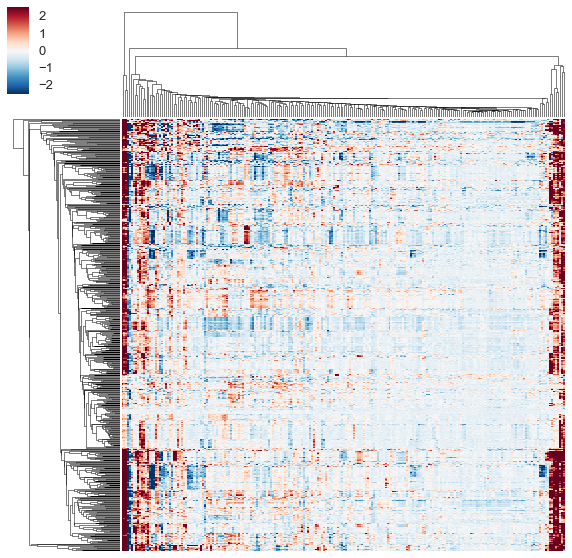

In [102]:
# sns.clustermap(SARAs[SARA_names],vmin=0,vmax=1,method="single",xticklabels=True,yticklabels=False,cmap='Spectral_r',square=False)

sns.clustermap(nodes[SARA_names], vmin=-2.5,vmax=2.5,pivot_kws=None,xticklabels=False,yticklabels=False, 
               method='average', metric='euclidean',
               z_score=None, standard_scale=None, figsize=None, cbar_kws=None,
               row_cluster=True, col_cluster=True,
               row_linkage=None, col_linkage=None,
               row_colors=None, col_colors=None, mask=None)

# sns.clustermap(SARAs[SARA_names],vmin=-2,vmax=2,method="single",xticklabels=False,yticklabels=False,cmap='RdBu_r',square=False)

/Users/xiaolibird/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


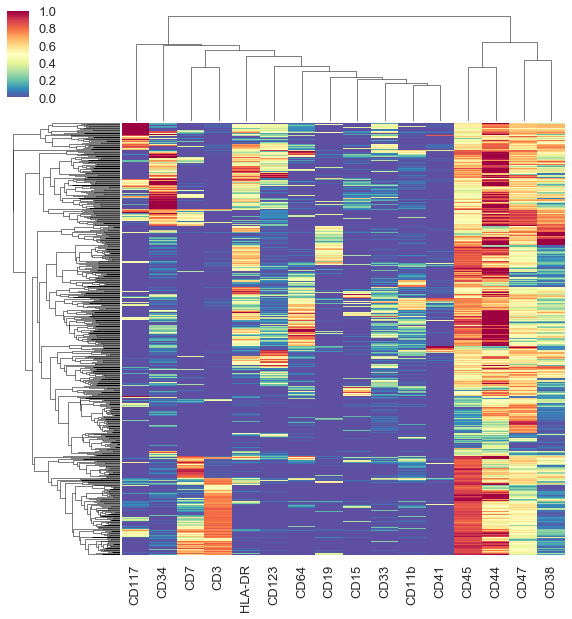

In [103]:
sns.clustermap(nodes[surface_markers], vmin=0.0,vmax=1,pivot_kws=None,
               xticklabels=True,yticklabels=False, method='average', metric='euclidean',
               cmap="Spectral_r",
               z_score=None, standard_scale=None, figsize=None, cbar_kws=None,
               row_cluster=True, col_cluster=True,
               row_linkage=None, col_linkage=None,
               row_colors=None, col_colors=None, mask=None)